# Applying Subtopic Ratings
<p>ADD INFOMRATION HERE</p>


## Step 0: Import packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import itertools
from collections import Counter

import pandas as pd

### Import Custom Plotting Functions

In [3]:
from plottingtools import compare_to_chain
from plottingtools import compare_to_zipcode
from plottingtools import compare_to_cuisine
from plottingtools import plot_suptopic_comparisons
from plottingtools import time_marker

## Step 1: Import Review Data with Subtopics

In [4]:
time_marker('Loading Restaurant Review data...')
reviews = pd.read_csv('../clean_data/az_restaurant_reviews_with_subtopics.csv', index_col=0, parse_dates=['date'], low_memory=False)

reviews.dropna(subset=['user_id'], inplace=True)

reviews.reset_index(inplace=True, drop=True)

reviews['chain_name'] = reviews['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')

time_marker('done')

[13:42:46.799143] Loading Restaurant Review data...
[13:42:57.109151] done


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495893 entries, 0 to 495892
Data columns (total 22 columns):
business_id         495893 non-null object
cool                495893 non-null int64
date                495893 non-null datetime64[ns]
funny               495893 non-null int64
review_id           495893 non-null object
stars               495893 non-null int64
text                495893 non-null object
useful              495893 non-null int64
user_id             495893 non-null object
is_fast_food        495893 non-null bool
review_len          495893 non-null int64
name                495893 non-null object
atmosphere          94385 non-null float64
value               159932 non-null float64
retention           225063 non-null float64
cleanliness         1795 non-null float64
ordering            36124 non-null float64
customer_service    285977 non-null float64
wait_time           89636 non-null float64
menu_options        12243 non-null float64
food_quality        299715

## Step 2: Calculate Subtopic Ratings for Each Business
<p>Yelp Review Star Rounding is performed by rounding up to the nearest half star, the same way Yelp rounds off Business Star Ratings</p>

In [7]:
# group reviews by business id
business_subtopic_ratings = reviews.groupby('business_id').mean()[reviews.columns[-10:-1]]

business_subtopic_ratings.head(10)

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
business_id,,,,,,,,,
-050d_XIor1NpCuWkbIVaQ,4.133333,3.889908,4.118497,1.5,3.652174,4.177249,3.939577,2.857143,3.843750
-092wE7j5HZOogMLAh40zA,4.277778,3.272727,3.760000,NaN,3.250000,3.511628,3.000000,4.000000,3.051724
-0Sgh0QlUKVsWosCWJzGqQ,4.333333,1.800000,2.176471,NaN,1.448276,2.272727,1.380952,1.000000,2.050000
-0WegMt6Cy966qlDKhu6jA,2.681818,2.320000,2.433333,NaN,1.333333,2.485714,1.794118,1.000000,2.115385
-17CAGmIRBHpPFlWBTDGuw,NaN,5.000000,1.000000,NaN,5.000000,1.000000,NaN,NaN,2.333333
-1VaIJza42Hjev6ukacCNg,4.347826,4.000000,4.000000,NaN,3.000000,4.066667,3.277778,NaN,3.518519
-2A9emZwBK8zYHPnAmM0hw,NaN,3.000000,3.333333,NaN,1.000000,3.400000,2.000000,NaN,2.166667
-2isRNVb6PDuBagELL5EBw,2.000000,4.000000,3.600000,NaN,2.250000,3.666667,3.000000,NaN,3.100000
-34vSRcMz_RjN00dWIiQ3Q,3.000000,2.333333,2.857143,NaN,NaN,3.125000,1.500000,NaN,2.714286


In [8]:
business_subtopic_ratings.describe()

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
count,5814.000000,6689.000000,6841.000000,1326.000000,5442.000000,6959.000000,6248.000000,3353.000000,7024.000000
mean,3.926962,3.256184,3.343873,2.833606,2.563436,3.511395,2.918466,3.531219,3.084629
std,0.969922,0.912155,0.985701,1.559800,1.146207,0.925220,1.081782,1.261665,0.865640
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.571429,2.800000,2.750000,1.000000,1.600000,3.000000,2.047619,3.000000,2.500000
50%,4.166667,3.400000,3.545455,3.000000,2.500000,3.679739,3.000000,4.000000,3.166667
75%,4.564538,3.888889,4.040404,4.000000,3.333333,4.191675,3.740159,4.500000,3.714286
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Step 3: Import Restaurant Business Data
<p>Merge Subtopic Ratings to business information DataFrame</p>

In [9]:
time_marker('Loading Restaurant Business data...')
biz_data = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)
biz_data = biz_data.iloc[:,:10].copy()

biz_data['chain_name'] = biz_data['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')


[13:42:58.115864] Loading Restaurant Business data...


In [10]:
# Merge Subtopic Ratings
biz_subtopics = biz_data.merge(business_subtopic_ratings, left_on='business_id', right_index=True)

In [11]:
biz_subtopics.head(3).transpose()

,0,1,2
address,777 E Thunderbird Rd Ste 107,10720 E Southern Ave,8140 N Hayden Rd Ste H115
business_id,1WBkAuQg81kokZIPMpn9Zg,kKx8iCJkomVQBdWHnmmOiA,VdlPZg2NAu8t8GkdbPLecg
categories,"['burgers', 'restaurants']","['restaurants', 'pizza']","['restaurants', 'gluten-free', 'indian', 'seaf..."
city,Phoenix,Mesa,Scottsdale
is_open,1,1,1
name,Charr An American Burger Bar,Little Caesars Pizza,Tandoori Times Indian Bistro
postal_code,85022,85209,85258
review_count,232,4,263
stars,3,2.5,3.5
is_fast_food,0,0,0


## Step 4: Plotting Subtopic Review Stars against Restaurant Star Ratings
<p>Restarants are givena single Star Rating, these ratings are compared to our calculated Rating for each of the 9 identified Sub Topics.  Using a set of box plots, we can see that Four possible trends appear.</p>


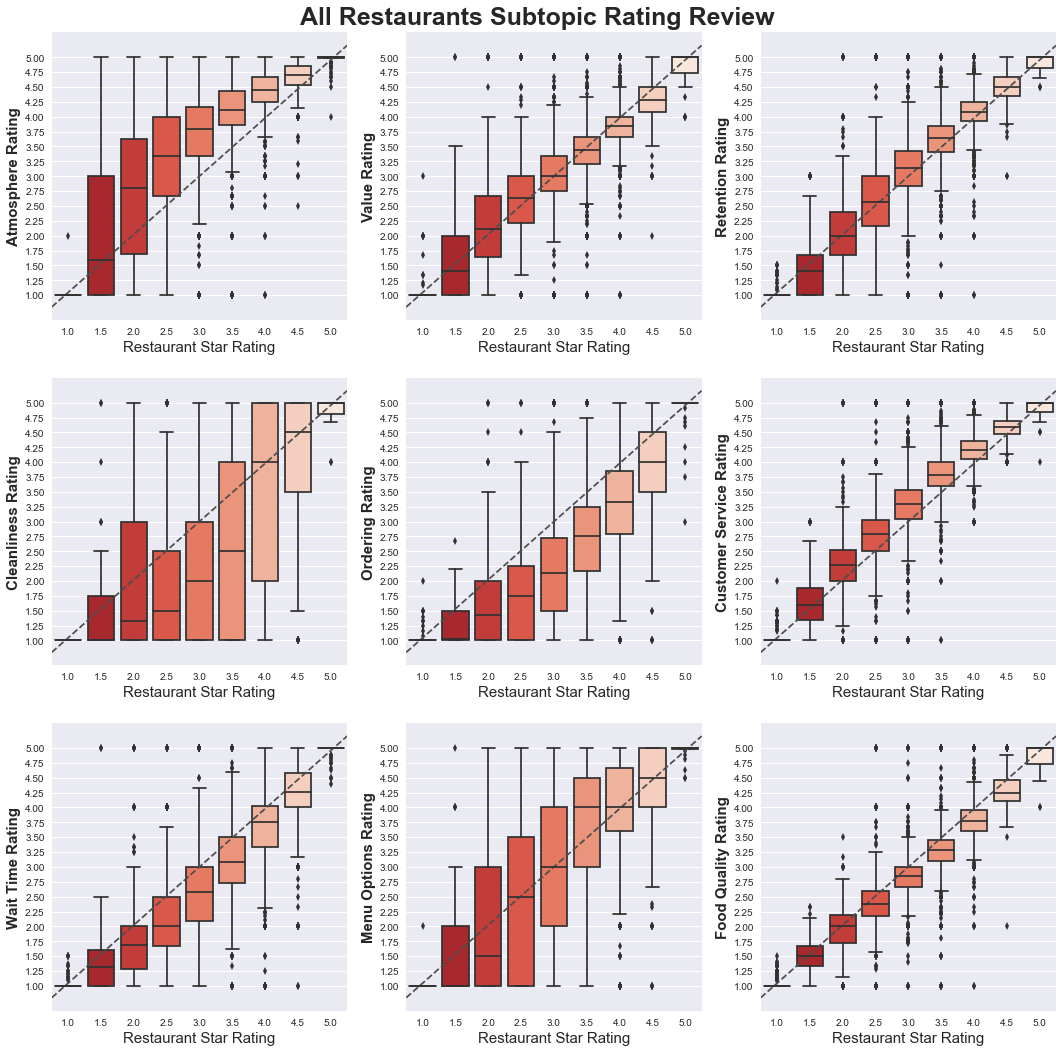

In [12]:
plot_suptopic_comparisons(biz_subtopics, palette='Reds_r', title_prefix='All Restaurants')

In [13]:
plot_suptopic_comparisons(biz_subtopics[biz_subtopics.is_fast_food == 0], palette='Greens_r', 
                          title_prefix='Non Fast Food Restaurants', show=False)

In [14]:
plot_suptopic_comparisons(biz_subtopics[biz_subtopics.is_fast_food == 1], palette='Blues_r',
                          title_prefix='Fast Food Restaurants', show=False)

## Step 5:  Compare Restaurant to Others in the same Chain
<p>Given a `business_id` this report shows the status of the given business in comparison to others bearing the same name.</p>

In [15]:
biz_data.head(3)

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food,chain_name
0,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"['burgers', 'restaurants']",Phoenix,1,Charr An American Burger Bar,85022.0,232,3.0,0,charr_an_american_burger_bar
1,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"['restaurants', 'pizza']",Mesa,1,Little Caesars Pizza,85209.0,4,2.5,0,little_caesars_pizza
2,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"['restaurants', 'gluten-free', 'indian', 'seaf...",Scottsdale,1,Tandoori Times Indian Bistro,85258.0,263,3.5,0,tandoori_times_indian_bistro


### Plot Business Rankings in Comparison to all Others in the Chain
<ul> Parameters
    <li><b>df</b>: the DataFrame of reviews to draw from</li>
    <li><b>bid</b>: the business_id of the business in question, this location is shown as a blue line in each Sub Rating</li>
    <li><b>min_reviews</b>: The minumum number of reviews for another business in the chain to be included</li>
    <li><b>min_biz</b>: The minumum number of other businesses in the chain.</li>
</ul>

### Identify Chains with most Locations

In [16]:
def get_top_n_chains(n, ff=''):

    if ff == 'ff':
        top_n_chains = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 1].chain_name).most_common(n)]
    elif ff == 'nff':
        top_n_chains = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 0].chain_name).most_common(n)]
    else:
        top_n_chains = [x[0] for x in Counter(biz_data.chain_name).most_common(n)]
        
    # etract business_id values of all retaurants in top_ten_chains
    top_n_chain_bids = list(reviews[reviews.chain_name.isin(top_n_chains)].business_id.unique())


    print('Working with reviews for {:d} Restaurants across {:d} Chains'.format(len(top_n_chain_bids), n))
    
    return top_n_chain_bids


In [17]:
all_chain_bids = get_top_n_chains(5)

Working with reviews for 696 Restaurants across 5 Chains


In [18]:
ff_chain_bids = get_top_n_chains(5, ff='ff')

Working with reviews for 696 Restaurants across 5 Chains


In [19]:
nff_chain_bids = get_top_n_chains(5, ff='nff')

Working with reviews for 258 Restaurants across 5 Chains


# UNCOMMENT THIS TO RUN ALL CHARTS

In [20]:
[compare_to_chain(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in all_chain_bids[:2]]
[compare_to_chain(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in ff_chain_bids[:2]]
[compare_to_chain(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in nff_chain_bids[:2]]

['../charts/reports/chain/barrospizza_0Rni7ocMC_Lg2UH0lDeKMQ_chain_comparison.png',
 '../charts/reports/chain/filibertosmexicanfood_mcXRNuN1MsgXYt8B2MWz2Q_chain_comparison.png']

### Plot Business Rankings in Comparison to all Others in the same Zipcode
<ul> Parameters
    <li><b>df</b>: the DataFrame of reviews to draw from</li>
    <li><b>bid</b>: the business_id of the business in question, this location is shown as a blue line in each Sub Rating</li>
    <li><b>min_reviews</b>: The minumum number of reviews for another business in the chain to be included</li>
    <li><b>min_biz</b>: The minumum number of other businesses in the chain.</li>
</ul>

In [21]:
def get_top_n_zips(n, ff=''):

    if ff == 'ff':
        top_n_zips = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 1].postal_code).most_common(n)]
    elif ff == 'nff':
        top_n_zips = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 0].postal_code).most_common(n)]
    else:
        top_n_zips = [x[0] for x in Counter(biz_data.postal_code).most_common(n)]
        
        
    zip_bids = biz_data[biz_data.postal_code.isin(top_n_zips)]['business_id'].unique()
    return zip_bids

In [22]:
all_zip_bids = get_top_n_zips(5, ff='')
ff_zip_bids = get_top_n_zips(5, ff='ff')
nff_zip_bids = get_top_n_zips(5, ff='nff')

In [23]:
[compare_to_zipcode(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in all_zip_bids[:2]]
[compare_to_zipcode(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in ff_zip_bids[:2]]
[compare_to_zipcode(reviews, x, biz_subtopics=biz_subtopics, show=False) for x in nff_zip_bids[:2]]

['../charts/reports/zipcode/sandstonecafe_9zSRAOUIM3I2ZnY9xwvioQ_zipcode_comparison.png',
 '../charts/reports/zipcode/juliostoo_EC7NrIHKk6i3US_XJlDWDA_zipcode_comparison.png']

## Step 9: Compare by Cuisine

In [24]:
n = 10
cuisines = list(itertools.chain.from_iterable([x.split("'")[1::2] for x in biz_subtopics['categories']]))
top_n_cuisines = Counter(cuisines).most_common(n+2)[2:]
print(top_n_cuisines)
top_n_cuisines = [x[0] for x in top_n_cuisines]
print(top_n_cuisines)

[('mexican', 1220), ('sandwiches', 1043), ('pizza', 1003), ('burgers', 741), ('american_(traditional)', 699), ('italian', 607), ('chinese', 571), ('american_(new)', 498), ('breakfast_&_brunch', 427), ('chicken_wings', 350)]
['mexican', 'sandwiches', 'pizza', 'burgers', 'american_(traditional)', 'italian', 'chinese', 'american_(new)', 'breakfast_&_brunch', 'chicken_wings']


In [25]:
n=0
cuisine_restaurants = biz_subtopics[biz_subtopics['categories'].apply(lambda x: top_n_cuisines[n] in x )].copy()
cuisine_restaurants.head()

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food,chain_name,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
14,6715 E McDowell Rd,SAae44V24aD7y_HpgxjhPA,"['restaurants', 'mexican']",Mesa,1,Nando's Mexican Cafe,85215.0,192,3.5,0,nandos_mexican_cafe,4.043478,3.085106,3.771429,1.0,2.166667,3.620370,3.028571,3.4,3.000000
20,450 N Alma School R,1Nq7GxjvEDgAJxBeOjR_9Q,"['mexican', 'restaurants']",Mesa,1,Burrito Express,85201.0,92,2.5,0,burrito_express,2.727273,2.761905,2.666667,NaN,2.136364,2.692308,1.866667,2.5,2.446154
21,3218 E Mcdowell Rd,to2cGMKdaw7ZHbXMzpfhlA,"['restaurants', 'mexican']",Phoenix,0,Filiberto's Mexican Rest,85008.0,7,3.0,0,filibertos_mexican_rest,1.000000,2.000000,4.500000,NaN,NaN,3.500000,NaN,NaN,2.000000
22,13132 W Camelback Rd,-Ut87cwGFsO3444Rd11p0Q,"['mexican', 'restaurants']",Litchfield Park,1,Federico's Mexican Food,85340.0,63,3.5,0,federicos_mexican_food,4.000000,3.214286,3.700000,NaN,1.500000,3.736842,3.545455,4.0,2.967742
29,1530 S Val Vista Dr,HQObn6hrV9WoeFObGfa2YQ,"['restaurants', 'tacos', 'mexican']",Gilbert,1,Mucha Lucha Taco Shop,85296.0,199,4.5,0,mucha_lucha_taco_shop,4.307692,4.333333,4.347107,NaN,3.285714,4.562963,4.093750,4.8,4.085470


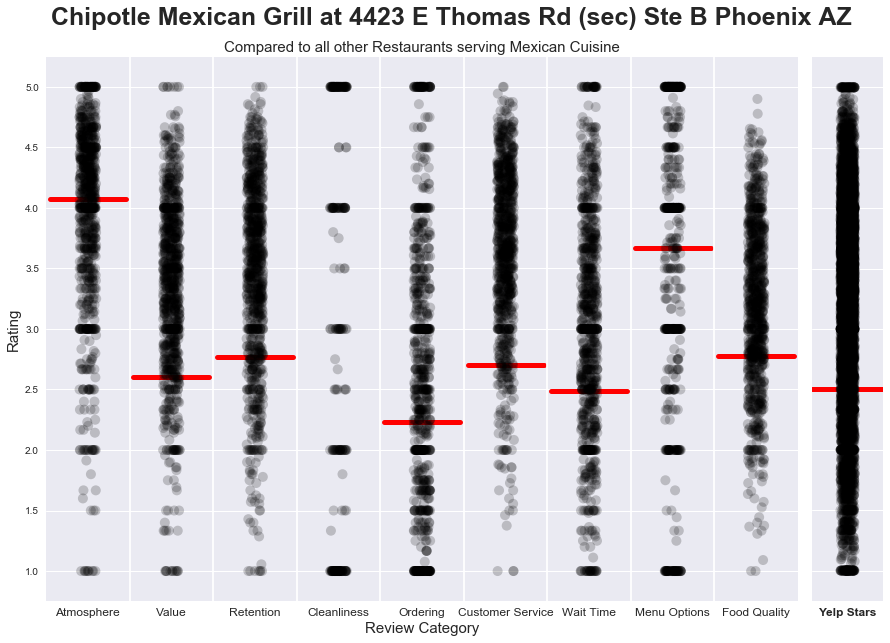

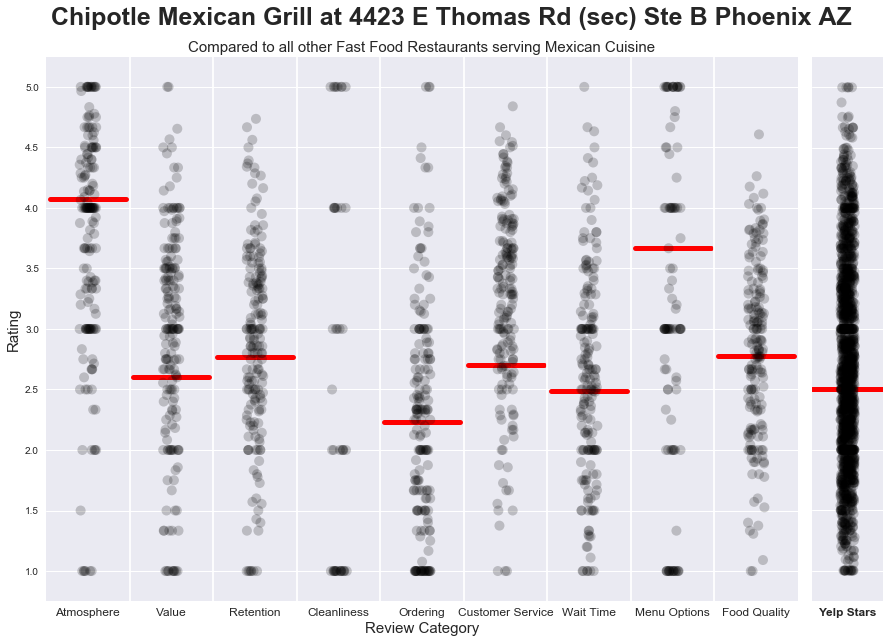

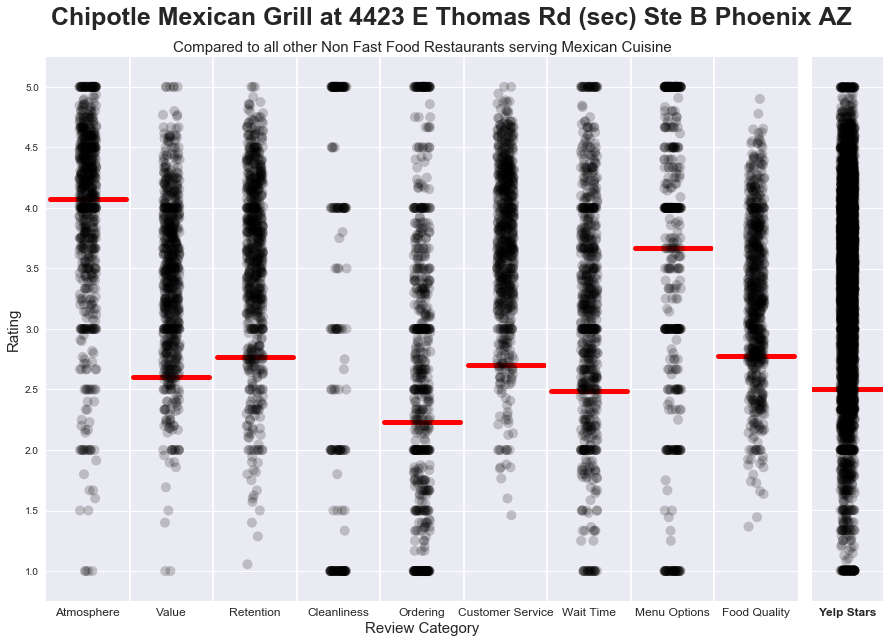

'../charts/reports/cuisine/chipotlemexicangrill_uovqgCcWIqTwUeH_A54t2A_cuisine_comparison_nff.png'

In [26]:
bid = 'uovqgCcWIqTwUeH_A54t2A'
compare_to_cuisine(reviews, 'mexican', bid, reviews, min_reviews=10, biz_subtopics=biz_subtopics, min_biz=5, show=True)
compare_to_cuisine(reviews[reviews.is_fast_food == 1], 'mexican', bid, reviews, biz_subtopics=biz_subtopics, min_reviews=10, min_biz=5, show=True, file_suffix='ff')
compare_to_cuisine(reviews[reviews.is_fast_food == 0], 'mexican', bid, reviews, biz_subtopics=biz_subtopics, min_reviews=10, min_biz=5, show=True, file_suffix='nff')
